**CS-401 Applied Data Analysis**  
**Project Milestone 2** 

**Group ID:** TheSuricates  

# **Budget Battles:** Maximizing Returns in Filmmaking Odyssey

In [40]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

from helpers import convert_to_datetime



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import TMDB dataset

In [33]:
PATH = './data/'

character = pd.read_csv(PATH + 'tmdb_person.csv')
movie = pd.read_csv(PATH + 'tmdb_movies.csv')

# Cleaning data

We will first remove all the *missing values* in the features we will use. 
As we need information about both the **movie** and the **characters** in it for our analysis, we will keep only the rows which are common in both movie and character dataframes. 

In [34]:
# Remove rows in the movie dataframe containing NaNs on features we will use
cleaned_movie = movie.copy()
cleaned_movie.dropna(subset=['budget', 'revenue', 'release_date', 'runtime',
                              'original_language', 'genres'], inplace=True)


# Remove rows in the character dataframe without actor names
cleaned_character = character.copy()
cleaned_character.dropna(subset=['name','birthday'], inplace=True)

# Preparing movie features

Let's create our own dataframe with some features which could have an effect on the `multiplier` of the money earned relative to the money invested in the film.

First we will use features which already exist in the movie metadata : the `runtime`, movie `country` and `genre`. We will also need to keep the `wikipedia id`, the `name` of the movie, the `release date` and the `box office` revenue for our analysis.

In [35]:
# Create a new dataframe using movie information
movie_features = cleaned_movie[['budget', 'revenue', 'release_date', 'runtime',
                              'original_language', 'genres']].copy()
movie_features.head()

,budget,revenue,release_date,runtime,original_language,genres
0,95000000.0,107900000.0,2023-10-12,92.0,en,"[{'id': 16, 'name': 'Animation'}, {'id': 10751..."
1,80000000.0,104000000.0,2023-09-27,134.0,en,"[{'id': 878, 'name': 'Science Fiction'}, {'id'..."
2,100000000.0,950200000.0,2023-07-19,181.0,en,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name..."
3,20000000.0,271900000.0,2023-10-25,110.0,en,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n..."
4,36150000.0,136698671.0,2023-09-07,169.0,hi,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."


We will also create new features from the character metadata : 
- the `number of characters` per movie
- the `average experience` of actors : the average upon all actors of the number of movies they appear in (before the movie)
- the `male ratio` of actors
- the `ratio of young actors` (below 18 years old)
- the `ratio of old actors` (above 60 years old)

In [36]:
#restructuring the character dataframe 

cleaned_character["movie_id"] = cleaned_character["played_in_movie_id"].apply(json.loads) #type cast string to list
cleaned_character = cleaned_character.explode("movie_id") #now every row is a different movie id
cleaned_character = cleaned_character.drop('played_in_movie_id', axis=1)


In [37]:
cleaned_character = cleaned_character.merge(cleaned_movie[['id', 'release_date']],left_on="movie_id",right_on="id",how ="left")
cleaned_character.dropna(subset=['release_date'], inplace=True)
cleaned_character = cleaned_character.drop(columns='id_y')
cleaned_character["actor_id"] = cleaned_character["id_x"]


In [38]:
cleaned_character.columns

Index(['adult', 'also_known_as', 'biography', 'birthday', 'deathday', 'gender',
       'homepage', 'id_x', 'imdb_id', 'known_for_department', 'name',
       'place_of_birth', 'popularity', 'profile_path', 'status_code_x',
       'status_message_x', 'success_x', 'crew', 'status_code_y',
       'status_message_y', 'success_y', 'movie_id', 'release_date',
       'actor_id'],
      dtype='object')

In [39]:
cleaned_character.drop_duplicates(subset=['actor_id', 'movie_id'],inplace=True)

In [53]:
def actor_age_for_movie(df):
   
   release_date = df.release_date.apply(convert_to_datetime).dt.year
   birth_date = df.birthday.apply(convert_to_datetime).dt.year
   
   age = int((release_date-birth_date).iloc[0])
   return age
       

cleaned_character["age"] = cleaned_character.groupby(level=0).apply(actor_age_for_movie)




## Working until here

In [48]:


# Total number of characters, number by age category and by gender
counts = cleaned_character.groupby('movie_id').agg(
    numberOfCharacters=('actorName', 'size'),
    below18=('actorAge', lambda x: (x < 18).sum()),
    above60=('actorAge', lambda x: (x > 60).sum()),
    maleRatio=('actorGender', lambda x: (x == 'M').sum())
).reset_index()

# We change the number of characters by age/gender by the ratio above total number of characters
counts['below18'] = counts['below18'] / counts['numberOfCharacters']
counts['above60'] = counts['above60'] / counts['numberOfCharacters']
counts['maleRatio'] = counts['maleRatio'] / counts['numberOfCharacters']

# Add the new columns to our movie_features dataframe
movie_features = pd.merge(movie_features, counts, left_on='wikiPageID', right_on='wikiPageID', how='left')
movie_features.head()

TypeError: apply() missing 1 required positional argument: 'func'

In [288]:
# Actors' experience
# Sort by the date of release (dor) within each actor group
sorted_character = cleaned_character.sort_values(['actorName', 'DateOfRelease'])

# Calculate cumulative count of movies for each actor up to the current movie
sorted_character['cumulative_movie_count'] = sorted_character.groupby('actorName').cumcount()

# Group by movie (wiki_id) and calculate the mean upon all actors of cumulative movie counts for each movie
experience_per_movie = sorted_character.groupby('wikiPageID')['cumulative_movie_count'].mean().reset_index()
experience_per_movie.columns = ['wikiPageID', 'averageActorsExperience']

# Merge with the 'movie_features' dataframe
movie_features = pd.merge(movie_features, experience_per_movie, on='wikiPageID', how='left')
movie_features.head()

,wikiPageID,movieName,movieReleaseDate,cost,boxOffice,movieRuntime,movieCountries,movieGenres,numberOfCharacters,below18,above60,maleRatio,averageActorsExperience
0,398934.0,10 Things I Hate About You,1999-03-31,13000000.0,53478579.0,97.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",13,0.076923,0.000000,0.538462,0.307692
1,14979283.0,10 to Midnight,1983,4520000.0,7175592.0,103.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",11,0.000000,0.090909,0.636364,0.727273
2,30575.0,Twelve Monkeys,1995-12-27,29500000.0,168839459.0,131.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",9,0.000000,0.111111,0.888889,0.777778
3,25244870.0,127 Hours,2010-09-04,18000000.0,60000000.0,90.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03bxz7"": ""Biogra...",18,0.055556,0.000000,0.555556,0.666667
4,407288.0,2 Fast 2 Furious,2003-06-03,76000000.0,236350661.0,101.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",15,0.000000,0.000000,0.866667,0.266667


### Features

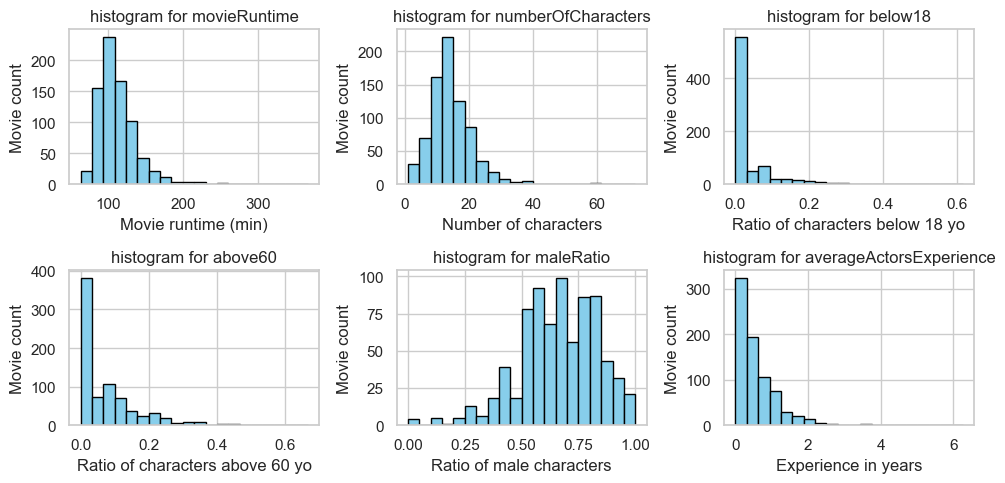

In [428]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

# Flatten the axes array for easier indexing
axes = axes.flatten()

list_of_features = ['movieRuntime', 'numberOfCharacters', 'below18', 'above60', 'maleRatio', 'averageActorsExperience']
list_title = ['Movie runtime (min)', 'Number of characters', 'Ratio of characters below 18 yo','Ratio of characters above 60 yo', 'Ratio of male characters', 'Experience in years']
# Create histograms in each subplot
for i in range(6):
    axes[i].hist(movie_features[list_of_features[i]], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'histogram for {list_of_features[i]}')
    axes[i].set_xlabel(f'{list_title[i]}')
    axes[i].set_ylabel('Movie count')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

We can observe from the histograms above that we have distinct distributions for all the features. This implies that we would be able to optimize the `multiplier` by adjusting the feature values. These will be optimized after the regression.

# Separate low and high budget movies

### Removing outliers

First, we will eliminate outliers from our data concerning the `multiplier` between the `cost` and the `boxOffice`. Some multipliers are excessively large, potentially inaccurately reported in Wikidata. To address this, we filter out data below the 2nd quantile and above the 98th quantile. Additionally, we exclude extremely low and excessively high budgets deemed incorrect.

In [289]:
# Create a new column corresponding to the ratio between the revenue and budget of the movie
movie_features['multiplier'] = movie_features['boxOffice'] / movie_features['cost']

outliers = (movie_features['multiplier']  < movie_features['multiplier'].quantile(0.02)) | (movie_features['multiplier']  > movie_features['multiplier'].quantile(0.98))
to_high_budget = 1*10**10
to_low_budget = 1.2*10**4

# Remove outliers from the movie_features dataframe
movie_features_no_outliers = movie_features[(movie_features['multiplier'] != outliers) & (movie_features['cost'] < to_high_budget) & (movie_features['cost'] > to_low_budget)]

In [346]:
print('There remain {} movies in the movie_features_no_outliers dataset'.format(len(movie_features_no_outliers)))

There remain 762 movies in the movie_features_no_outliers dataset


We can see that from the 810 movies from the merged dataset with Wikidata, we keep 762 after cleaning the dataset and removing the outliers.

In [ ]:
# Convert the movies date of release to datetime
movie_features_no_outliers['movieReleaseDate'] = movie_features_no_outliers['movieReleaseDate'].apply(convert_to_datetime)

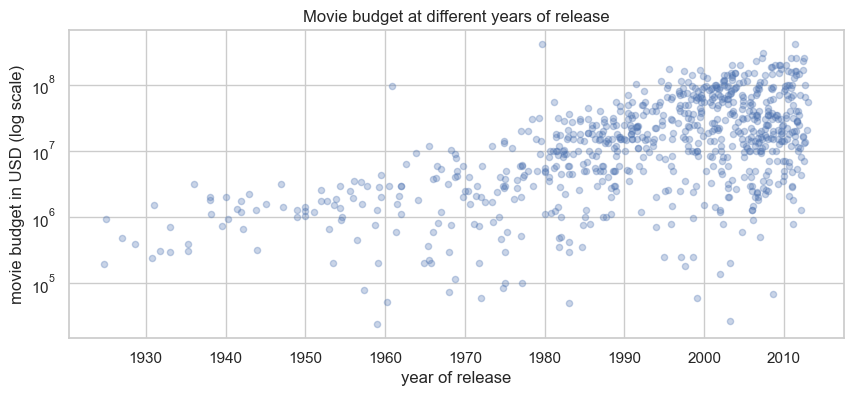

In [417]:
# Plot the movie budget at different years of release
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(movie_features_no_outliers['movieReleaseDate'], movie_features_no_outliers['cost'], alpha=0.3, s=20)
plt.title('Movie budget at different years of release')
plt.xlabel('year of release')
plt.ylabel('movie budget in USD (log scale)')
plt.yscale('log')
plt.show()

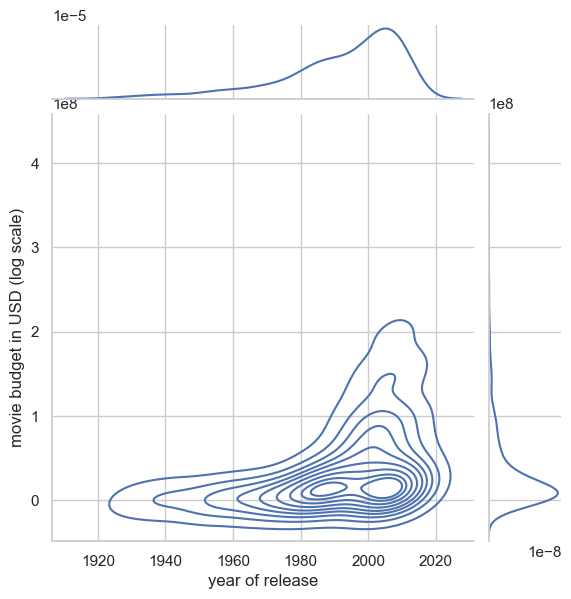

In [442]:
# Let's plot the movie budget in another way to better see the distribution
sns.jointplot(data=movie_features_no_outliers, x='movieReleaseDate', y='cost', kind='kde').set_axis_labels('year of release', 'movie budget in USD (log scale)')
plt.show()


The scatterplot gave us a first insight about the data distribution over the years. The graph above draws both bivariate and univariate Kernel Density Estimations (KDEs) to have a smoother and cleaner representation of the movie budget data over the years.

### Separate in low and high budget categories

To distinguish between `low` and `high`-budget films, we categorize films into five-year groups based on their release dates. The top 25% of films with the highest budgets and the bottom 25% with the lowest budgets are then identified within each time frame. This process mitigates the impact of ***inflation*** on budget categorization. Subsequently, all high-budget films from different periods will be regrouped into a single high-budget category, and the same will be done for low-budget films.

In [ ]:
min_year = movie_features_no_outliers['movieReleaseDate'].min().year
max_year = movie_features_no_outliers['movieReleaseDate'].max().year

# Create a new column corresponding to the year of release of the movie
movie_features_no_outliers['year'] = movie_features_no_outliers['movieReleaseDate'].dt.year 
movie_features_no_outliers['year_group'] = movie_features_no_outliers['year']

df_low_budget_movie = pd.DataFrame(columns=movie_features_no_outliers.columns)
df_high_budget_movie = pd.DataFrame(columns=movie_features_no_outliers.columns)

year = min_year
while year < max_year:
    # Select movies released by 5 years interval
    movies = movie_features_no_outliers[(movie_features_no_outliers['year'] >= int(year)) & (movie_features_no_outliers['year'] < int(year + 5))]
    # Add the movies with the highest and lowest budget to the corresponding dataframe
    movies['year_group'] = year
    df_high_budget_movie = pd.concat([pd.DataFrame(movies[movies['cost'] > movies['cost'].quantile(0.75)]),df_high_budget_movie], ignore_index=True)
    df_low_budget_movie = pd.concat([pd.DataFrame(movies[movies['cost'] < movies['cost'].quantile(0.25)]),df_low_budget_movie], ignore_index=True)
    year += 5


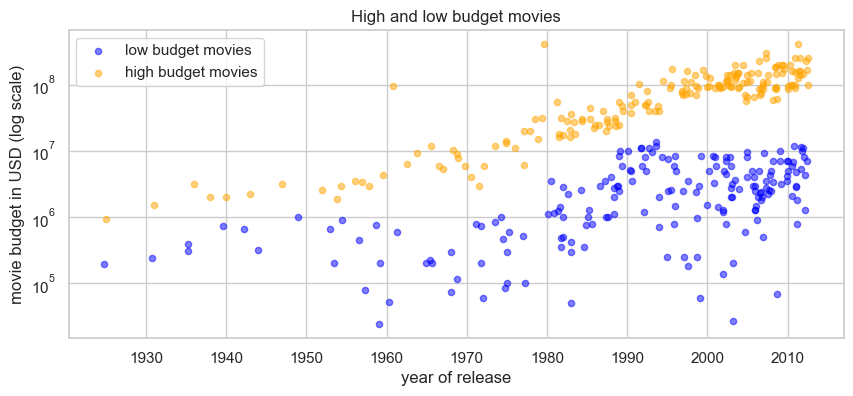

In [397]:
# Plot the high and low budget movies at different years of release
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(df_low_budget_movie['movieReleaseDate'], df_low_budget_movie['cost'], label='low budget movies', color='blue', alpha=0.5, s=20)
plt.scatter(df_high_budget_movie['movieReleaseDate'], df_high_budget_movie['cost'], label='high budget movies', color='orange', alpha=0.5, s=20)
plt.title('High and low budget movies')
plt.xlabel('year of release')
plt.ylabel('movie budget in USD (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

We observe a distinct separation between `low` and `high` budgets. The graph illustrates that the definition of low and high budgets changes over the years, following a logarithmic function.


In [347]:
print('There are {} low budget movies'.format(len(df_low_budget_movie)))
print('There are {} high budget movies'.format(len(df_high_budget_movie)))

There are 188 low budget movies
There are 183 high budget movies


In [378]:
df_low_budget_movie['category'] = 'low'
df_high_budget_movie['category'] = 'high'
df = pd.concat([df_low_budget_movie, df_high_budget_movie], ignore_index=True) 

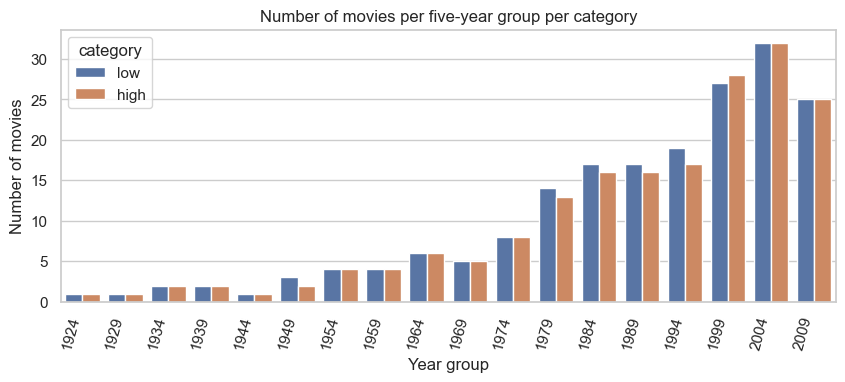

In [385]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(data=df, x='year_group', hue='category')
ax.set_title('Number of movies per five-year group per category')
ax.set_xlabel('Year group')
ax.set_ylabel('Number of movies')
fig.autofmt_xdate(rotation = 75)

By selecting the 25% lowest and highest values for each five-year group, we approximately have the same number of films from each year group. The higher count of films in recent years is attributed to the greater number of films recorded in the dataset from those years.

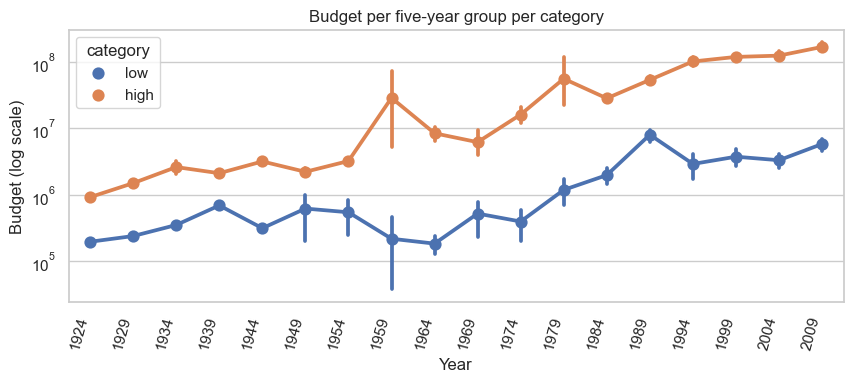

In [387]:
fig, ax = plt.subplots(figsize=(10, 4))

# Ploting the corresponding fraction of missing salary by year
sns.pointplot(data=df, x='year_group', y='cost', hue='category', errorbar=('ci', 95))

ax.set_title('Budget per five-year group per category')
ax.set_xlabel('Year')
ax.set_yscale('log')
ax.set_ylabel('Budget (log scale)')
ax.legend(title='category')

fig.autofmt_xdate(rotation = 75)

plt.show()

We can observe from the above graph that films with high and low budgets have non-overlapping 95% confidence intervals. This indicates that the films are effectively distinguished.